# Analysis on Application Data for AdvisorySG

- Load in mentor info data from elastic search to enrich and supplement dataset
- 2 versions of preprocessed dataset has been created under ./data/mentors_per_application.csv and ./data/mentors.csv
- Analysis on basic counts in Application data for ./datamentors.csv
- Analysis on per application records for ./datamentors_per_application.csv

### Load in Mentor Info Data From Elastic Search

In [ ]:
import pandas as pd
import numpy as np

# !pip install elasticsearch

In [ ]:
# create a client instance of the library
from elasticsearch import Elasticsearch

CLOUD_ID = "<CLOUD_ID>"
PASSWORD = '<PASSWORD>'

es = Elasticsearch(
    cloud_id=CLOUD_ID,
    http_auth=('jolene', PASSWORD)
)

# make an API call to the Elasticsearch cluster to get documents
result = es.search(index="enterprise-search-engine-mentorship-page", body={
    "query": {
        "match_all": {}
    }
}, size=20)

# search by keyword
# result = es.search(index=1, body={"query": {"match": {"title": "python"}}}, size=20)
result

In [55]:
import re

def getMentorInfoByName(name):
    search_options = {
        'query': {
            'bool': {
                'should': []
            }
        }
    }

    # Add match query for the name
    search_options['query']['bool']['should'].append({
        'match': {
            'name': name
        }
    })

    # Search by organization if name includes organization information in brackets
    organization = re.search(r'\((.*?)\)', name)
    if organization:
        organization_name = organization.group(1)
        # Add match query for the organisation
        search_options['query']['bool']['should'].append({
            'match': {
                'organisation': organization_name
            }
        })

    result = es.search(
        index='enterprise-search-engine-mentorship-page',
        body=search_options
    )
    exact_matches = [doc for doc in result['hits']['hits']]

    if len(exact_matches) == 0:
        return None
    
    if 'organisation' in exact_matches[0]['_source']:
        return {
            'name': exact_matches[0]['_source']['name'],
            'industries': exact_matches[0]['_source']['industries'],
            'organisation': exact_matches[0]['_source']['organisation']
        }
    else:
        return {
            'name': exact_matches[0]['_source']['name'],
            'industries': exact_matches[0]['_source']['industries'],
            'organisation': None
        }

# check if any mentors have the same name
def checkSameName(name):
    search_options = {
        'query': {
            'match': {
                'name': name
            }
        }
    }
    result = es.search(
        index='enterprise-search-engine-mentorship-page',
        body=search_options
    )
    documents = result['hits']['hits']
    if len(documents) > 1:
        return True
    else:
        return False

getMentorInfoByName('chew jia ying')

C:\Users\jolen\AppData\Local\Temp\ipykernel_448\343203947.py:30: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(


{'name': 'Jia Ying Chew',
 'industries': ['Design'],
 'organisation': 'National University of Singapore'}

with basic frequency analysis of popular industries, see if per-application data would be useful

In [56]:
# load in csvs 2020w3, 2021w1 and 2022
df_2020w3 = pd.read_csv('data/2020w3.csv')
df_2021w1 = pd.read_csv('data/2021w1.csv')
df_2022 = pd.read_csv('data/2022.csv')

# get first 3 columns of all files and rename them to mentor_1, mentor_2, mentor_3
df_2020w3 = df_2020w3.iloc[:, 0:3]
df_2020w3.columns = ['mentor_1', 'mentor_2', 'mentor_3']

df_2021w1 = df_2021w1.iloc[:, 0:3]
df_2021w1.columns = ['mentor_1', 'mentor_2', 'mentor_3']

df_2022 = df_2022.iloc[:, 0:3]
df_2022.columns = ['mentor_1', 'mentor_2', 'mentor_3']

df_per_application = pd.concat([df_2020w3, df_2021w1, df_2022])
df_per_application['year'] = np.concatenate([np.full(len(df_2020w3), "2020w3"), np.full(len(df_2021w1), "2021w1"), np.full(len(df_2022), "2022")])
df_per_application = df_per_application[df_per_application['mentor_1'] != '[INSERT NAME LIST OF WAVE 3 MENTORS]']

# combine all 3 columns into 1
df_2020w3 = pd.concat([df_2020w3['mentor_1'], df_2020w3['mentor_2'], df_2020w3['mentor_3']])
df_2021w1 = pd.concat([df_2021w1['mentor_1'], df_2021w1['mentor_2'], df_2021w1['mentor_3']])
df_2022 = pd.concat([df_2022['mentor_1'], df_2022['mentor_2'], df_2022['mentor_3']])

# combine all 3 dataframes into 1 and add a column for the year
df = pd.concat([df_2020w3, df_2021w1, df_2022])
df = df.to_frame()
df['year'] = np.concatenate([np.full(len(df_2020w3), "2020w3"), np.full(len(df_2021w1), "2021w1"), np.full(len(df_2022), "2022")])

# rename first column to mentor_name
df.columns = ['mentor_name', 'year']

# remove the row with [INSERT NAME LIST OF WAVE 3 MENTORS]
df = df[df['mentor_name'] != '[INSERT NAME LIST OF WAVE 3 MENTORS]']

display(df.head())
display(df_per_application.head())

,mentor_name,year
1,Aaqib Alvi,2020w3
2,Alvin Seo,2020w3
3,Daniel Ho,2020w3
4,Junhao Tan,2020w3
5,Benjamin Oh,2020w3


,mentor_1,mentor_2,mentor_3,year
1,Aaqib Alvi,Abhi Parikh,Alex Loh,2020w3
2,Alvin Seo,Alvin Seo,Alvin Seo,2020w3
3,Daniel Ho,Andee Chua,Brad Verne,2020w3
4,Junhao Tan,Kevin Leung,Dennis Ly,2020w3
5,Benjamin Oh,Andrew Chia,Vina Misra,2020w3


In [7]:
# show me non strinr rows in mentor_name
df[~df['mentor_name'].apply(lambda x: isinstance(x, str))]

# remove NaN rows
df = df.dropna()
df_per_application = df_per_application.dropna()

Getting mentor information

In [ ]:
mentors = {}
unknown_mentors = []

# create new columns for industries and organisation
df["industries"] = ""
df["organisation"] = ""

# loop thru all mentors and get mentor details
for index, row in df.iterrows():
    name = row['mentor_name'].lower()
    year = row['year']

    if name in mentors:
        mentor = mentors[name]
    else:
        mentor = getMentorInfoByName(name)
    
    if mentor is not None:
        row["industries"] = mentor["industries"]
        row["organisation"] = mentor["organisation"]
    else:
        unknown_mentors.append(name)

# do the same for each column in application
df_per_application['mentor_1_industries'] = ""
df_per_application['mentor_1_organisation'] = ""
df_per_application['mentor_2_industries'] = ""
df_per_application['mentor_2_organisation'] = ""
df_per_application['mentor_3_industries'] = ""
df_per_application['mentor_3_organisation'] = ""

for index, row in df_per_application.iterrows():
    for i in range(1, 4):
        name = row[f'mentor_{i}'].lower()
        year = row['year']

        if name in mentors:
            mentor = mentors[name]
        else:
            mentor = getMentorInfoByName(name)
        
        if mentor is not None:
            row[f"mentor_{i}_industries"] = mentor["industries"]
            row[f"mentor_{i}_organisation"] = mentor["organisation"]
        else:
            unknown_mentors.append(name)

# unknown mentors
unknown_mentors = list(set(unknown_mentors))
print(unknown_mentors)

In [ ]:
len(unknown_mentors)

117

In [ ]:
len(unknown_mentors)

11

In [ ]:
unknown_mentors

['fahmi hamzah',
 'kamaladasan kalidasan',
 'ayushi bainwala',
 'shivina nainani',
 'chandini manoharan',
 'joeyee watt',
 'keerthana paramasivam',
 'ashleen ngion',
 'desiree tung',
 'sweeney lachman',
 'matin mohdari']

In [ ]:
# save to csv
df.to_csv('data/mentors.csv', index=False)
df_per_application.to_csv('data/mentors_per_application.csv', index=False)

### Analysis on basic counts of application data

In [10]:
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import GridSpec 

df = pd.read_csv('data/mentors.csv')
df_per_application = pd.read_csv('data/mentors_per_application.csv')
df['industries'] = df['industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_1_industries'] = df_per_application['mentor_1_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_2_industries'] = df_per_application['mentor_2_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_3_industries'] = df_per_application['mentor_3_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])


In [2]:
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import GridSpec 

df = pd.read_csv('data/mentors.csv')
df_per_application = pd.read_csv('data/mentors_per_application.csv')
df['industries'] = df['industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_1_industries'] = df_per_application['mentor_1_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_2_industries'] = df_per_application['mentor_2_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_per_application['mentor_3_industries'] = df_per_application['mentor_3_industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])

df.head()

,mentor_name,year,industries,organisation
0,Aaqib Alvi,2020w3,[Early Childhood Care and Education],Sustainable Living Lab
1,Alvin Seo,2020w3,"[Information and Communications Technology, Cl...",UBS
2,Daniel Ho,2020w3,[Information and Communications Technology],Mixpanel APAC Pte. Ltd.
3,Junhao Tan,2020w3,"[Banking and Finance, Marine and Offshore Engi...",OCBC Bank
4,Benjamin Oh,2020w3,[Security],Singapore Civil Defence Force


In [11]:
len(df_2020w3)/3

376.0

205


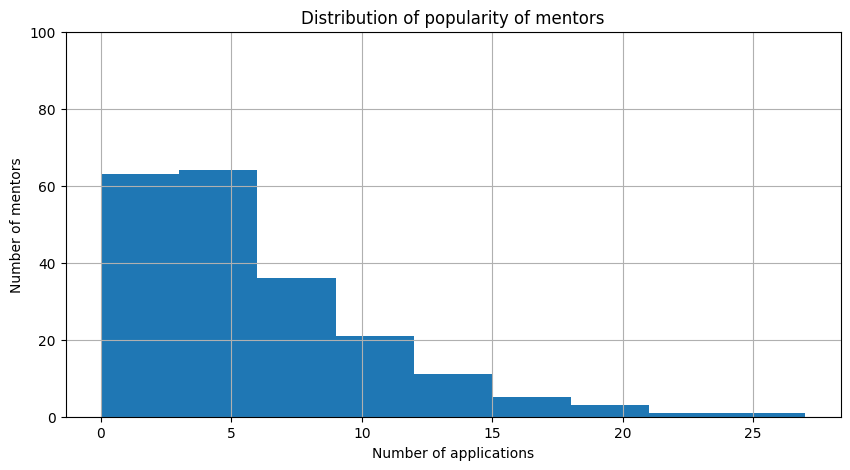

In [12]:
# how the popularity of mentors is distributed
# df['mentor_name'].value_counts().hist(bins=100)

# filter by year
df_2020w3 = df[df['year'] == '2020w3']

df_2020w3['mentor_name'].value_counts().hist(bins=range(0, max(df_2020w3['mentor_name'].value_counts()) + 6, 3), figsize=(10, 5))

# number of mentors in df_2020w3
print(len(df_2020w3['mentor_name'].value_counts()))

# add x and y axis labels
# plt.xlabel('Number of applications')
plt.ylabel('Number of mentors')
plt.title('Distribution of popularity of mentors')

plt.ylim(0, 100)

plt.show()

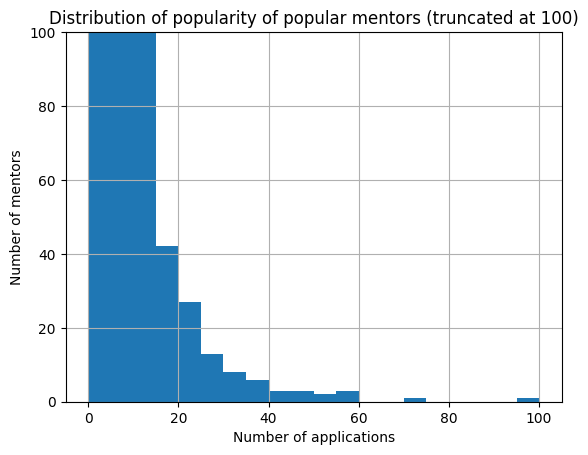

In [12]:
import matplotlib.pyplot as plt

# Calculate the mentor value counts
mentor_counts = df['mentor_name'].value_counts()

# Filter mentors with counts exceeding 100
popular_mentors = mentor_counts[mentor_counts <= 100]

# Plot the truncated histogram
popular_mentors.hist(bins=range(0, max(df['mentor_name'].value_counts()) + 6, 5))

plt.xlabel('Number of applications')
plt.ylabel('Number of mentors')
plt.title('Distribution of popularity of popular mentors (truncated at 100)')

# Set the y-axis limit to 100
plt.ylim(0, 100)

plt.show()

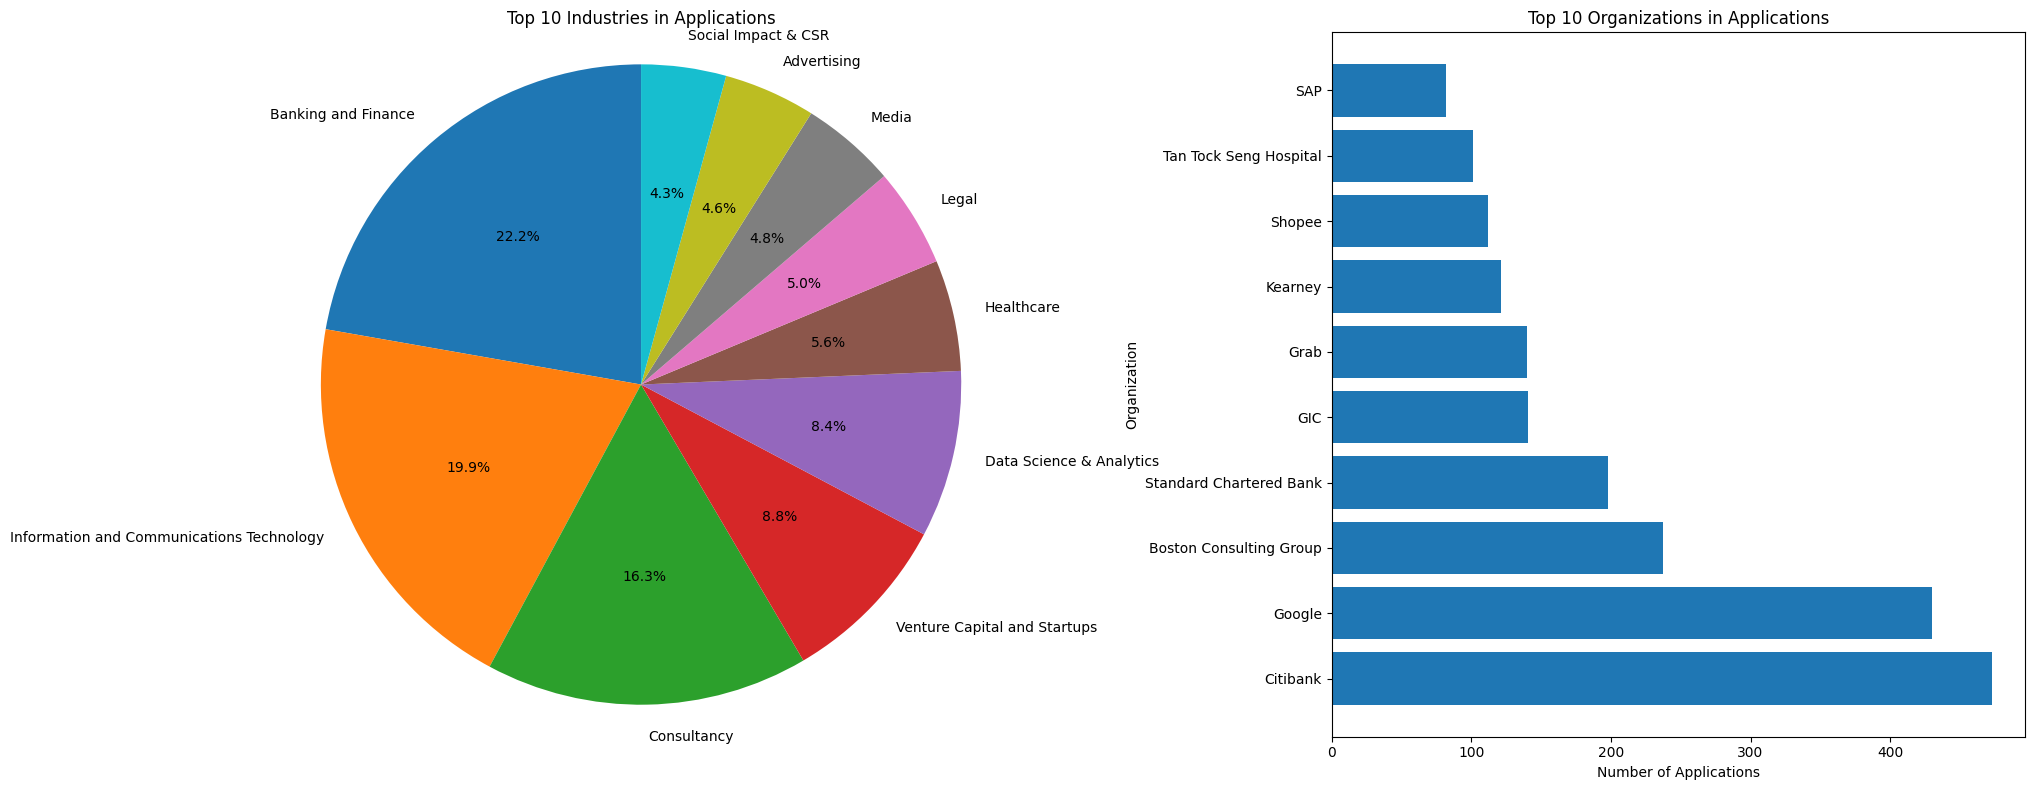

In [15]:
from matplotlib.gridspec import GridSpec

# get industries count
industry_counts = df['industries'].explode().value_counts(dropna=False)

# pie chart of top 10 industries, title and no axis labels
top_10_industries = industry_counts.head(10)

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax1.pie(top_10_industries, labels=top_10_industries.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Top 10 Industries in Applications')
ax1.axis('equal')

# most popular organizations, bar chart
top_10_organizations = df['organisation'].astype(str).value_counts(dropna=False).head(10)
ax2 = fig.add_subplot(gs[1])
ax2.barh(top_10_organizations.index, top_10_organizations.values)
ax2.set_title('Top 10 Organizations in Applications')
ax2.set_xlabel('Number of Applications')
ax2.set_ylabel('Organization')

plt.tight_layout()
plt.show()

Interestingly, the top 5 industries that were most popular among applications were Banking and Finance, Information and Communications Technology, Consultancy, Venture Capital and Startups and Data Science and Analytics. Which could signify the current trends in the industries. Google also was not the most popular organization with Citybank taking the lead.

This made me wonder what the connection was between the 2, to understand its relation and to understand which organizations were more preferred for each of the top 10 industries. What companies are people looking for to hear from in different industries?

Banking and Finance                          2538
Information and Communications Technology    2274
Consultancy                                  1861
Venture Capital and Startups                 1003
Data Science & Analytics                      962
Healthcare                                    641
Legal                                         569
Media                                         548
Advertising                                   529
Social Impact & CSR                           489
Name: industries, dtype: int64


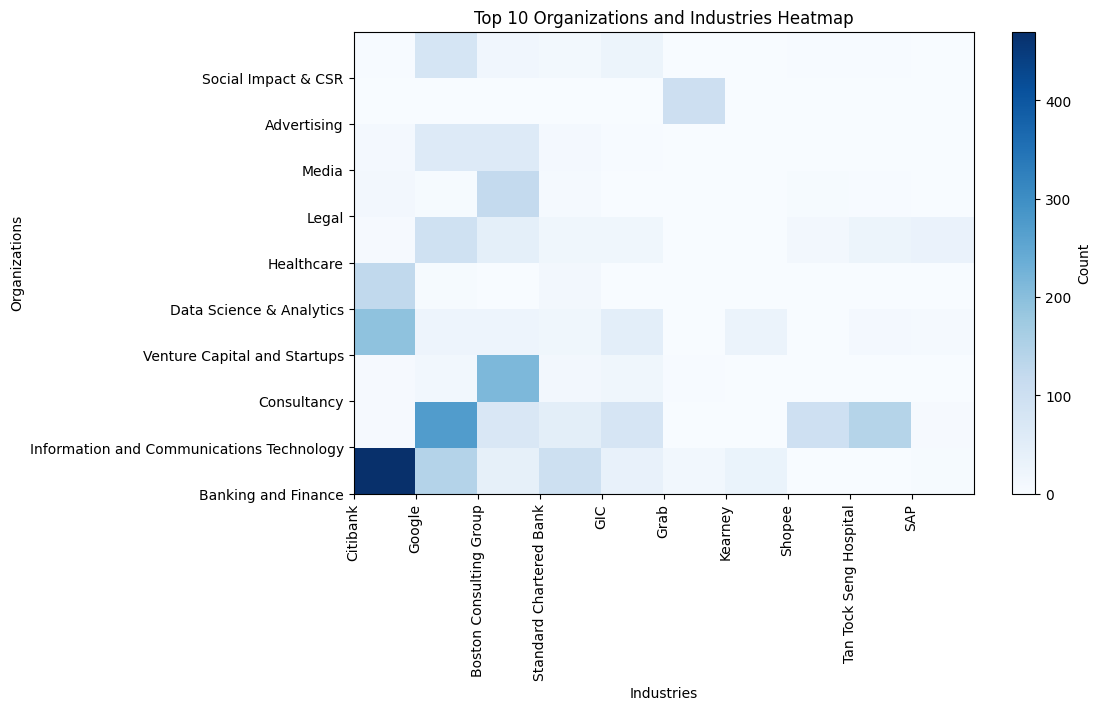

In [16]:
organization_counts = df['organisation'].value_counts().nlargest(10)
industry_counts = df['industries'].explode().value_counts().nlargest(10)
print(industry_counts)

df_exploded = df.explode('industries')
heatmap_data = df_exploded.groupby(['organisation', 'industries']).size().unstack().fillna(0)
heatmap_data = heatmap_data.loc[organization_counts.index, industry_counts.index]

plt.figure(figsize=(10, 6))
heatmap = plt.pcolor(heatmap_data, cmap='Blues')

plt.title('Top 10 Organizations and Industries Heatmap')
plt.xlabel('Industries')
plt.ylabel('Organizations')

plt.xticks(range(len(organization_counts)), organization_counts.index, rotation=90)
plt.yticks(range(len(industry_counts)), industry_counts.index)

# Add color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Count')

plt.show()

People in the banking and finance industry look mostly at Citibank, google and GIC. People in the IT industry look mostly at Google, Tan Tock Seng Hospital and Shopee. People in consultancy also very strongly only look at Boston Consulting Group which is interesting that though consulting is one of the biggest industries in the application data but applications are only coming from mainly 1 organization. Another interesting insight that for the field of data analytics and healthcare, citibank appears to also be the most popular organization.

emntors or application data TODO

C:\Users\jolen\AppData\Local\Temp\ipykernel_23624\2446591838.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_10_industries = industry_counts.groupby('industries').sum().sort_values('count', ascending=False).head(10).reset_index()


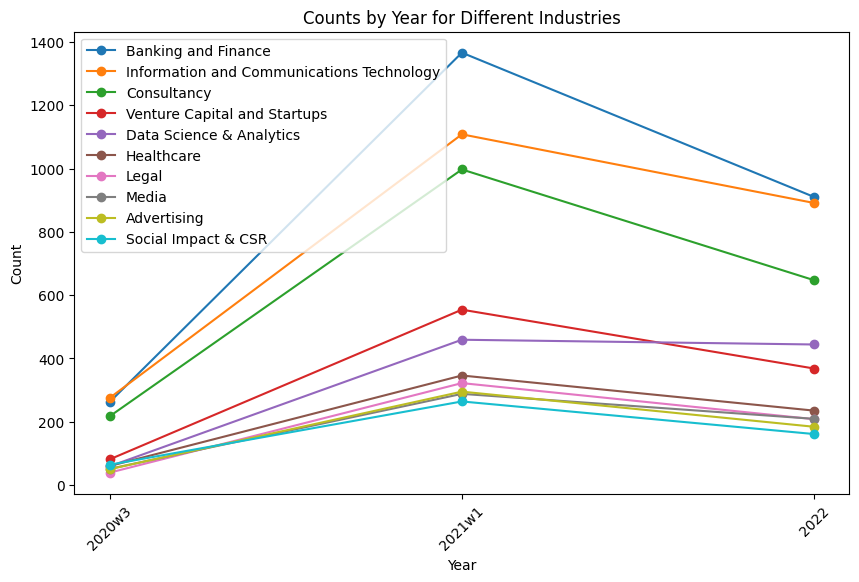

In [17]:
df_exploded = df.explode('industries')

industry_counts = df_exploded.groupby(['year', 'industries']).size().reset_index(name='count')

# get industries with top 10 highest counts
top_10_industries = industry_counts.groupby('industries').sum().sort_values('count', ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
num_colors = len(colors)
for i, industry in enumerate(top_10_industries['industries'].unique()):
    industry_data = industry_counts[industry_counts['industries'] == industry]
    color = colors[i % num_colors]  # cycling through colors
    plt.plot(industry_data['year'], industry_data['count'], marker='o', color=color, label=industry)

plt.title('Counts by Year for Different Industries')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data Science is seen to have gained in popularity in 2022 as compared to the previous years. Despite most applications numbers decreaseing, Data Science is the only ont that has increased among the top 10 most popular industries.

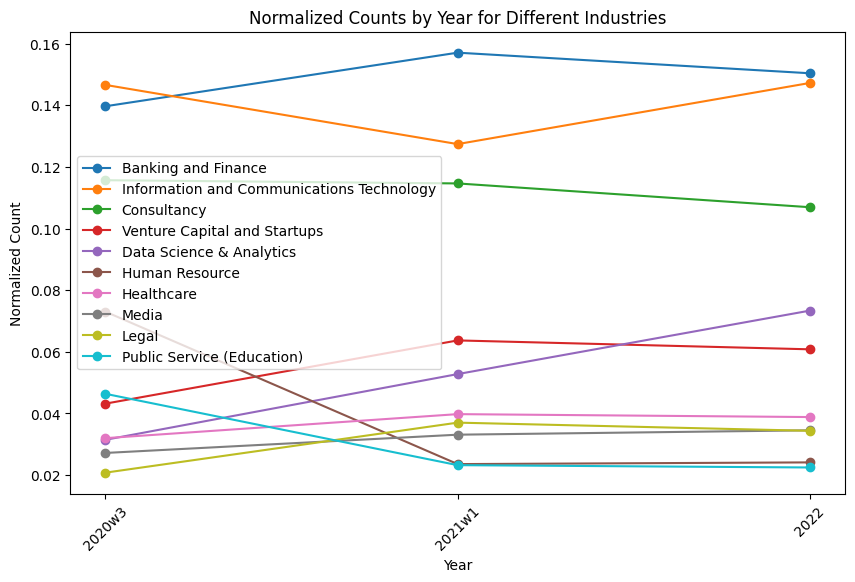

In [18]:
df_exploded = df.explode('industries')

industry_counts = df_exploded.groupby(['year', 'industries']).size().reset_index(name='count')

# Calculate the total count for each year
year_counts = industry_counts.groupby('year')['count'].sum()

# Normalize the counts by dividing each count by the total count for its year
industry_counts['normalized_count'] = industry_counts['count'] / industry_counts['year'].map(year_counts)

# Get industries with the top 10 highest normalized counts
top_10_industries = industry_counts.groupby('industries')['normalized_count'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
num_colors = len(colors)
for i, industry in enumerate(top_10_industries['industries'].unique()):
    industry_data = industry_counts[industry_counts['industries'] == industry]
    color = colors[i % num_colors]  # cycling through colors
    plt.plot(industry_data['year'], industry_data['normalized_count'], marker='o', color=color, label=industry)

plt.title('Normalized Counts by Year for Different Industries')
plt.xlabel('Year')
plt.ylabel('Normalized Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [19]:
df_exploded = df.explode('industries')
industry_counts = df_exploded.groupby(['industries']).size().reset_index(name='count')
industry_counts.sort_values('count', ascending=False).reset_index()

,index,industries,count
0,7,Banking and Finance,2538
1,26,Information and Communications Technology,2274
2,12,Consultancy,1861
3,47,Venture Capital and Startups,1003
4,13,Data Science & Analytics,962
5,23,Healthcare,641
6,30,Legal,569
7,34,Media,548
8,1,Advertising,529
9,43,Social Impact & CSR,489


### Analysis on Per Application Record: Market Basket Analysis

Key Takeaways:
- There aren't a lot of frequent combinations of mentors. As seen from the low support scores across all rules generated
    - When the support is not very high, it means that the itemset or combination of items occurs relatively infrequently in the dataset.
    - So the generated rules might be quite niche, this is probably due to many mentors in comparison to the application data
    - Highest count of same mentors chosen across the 3 selections is 19, which out of the 2777 records, is not a lot
- Mentors Commonly Chosen together
    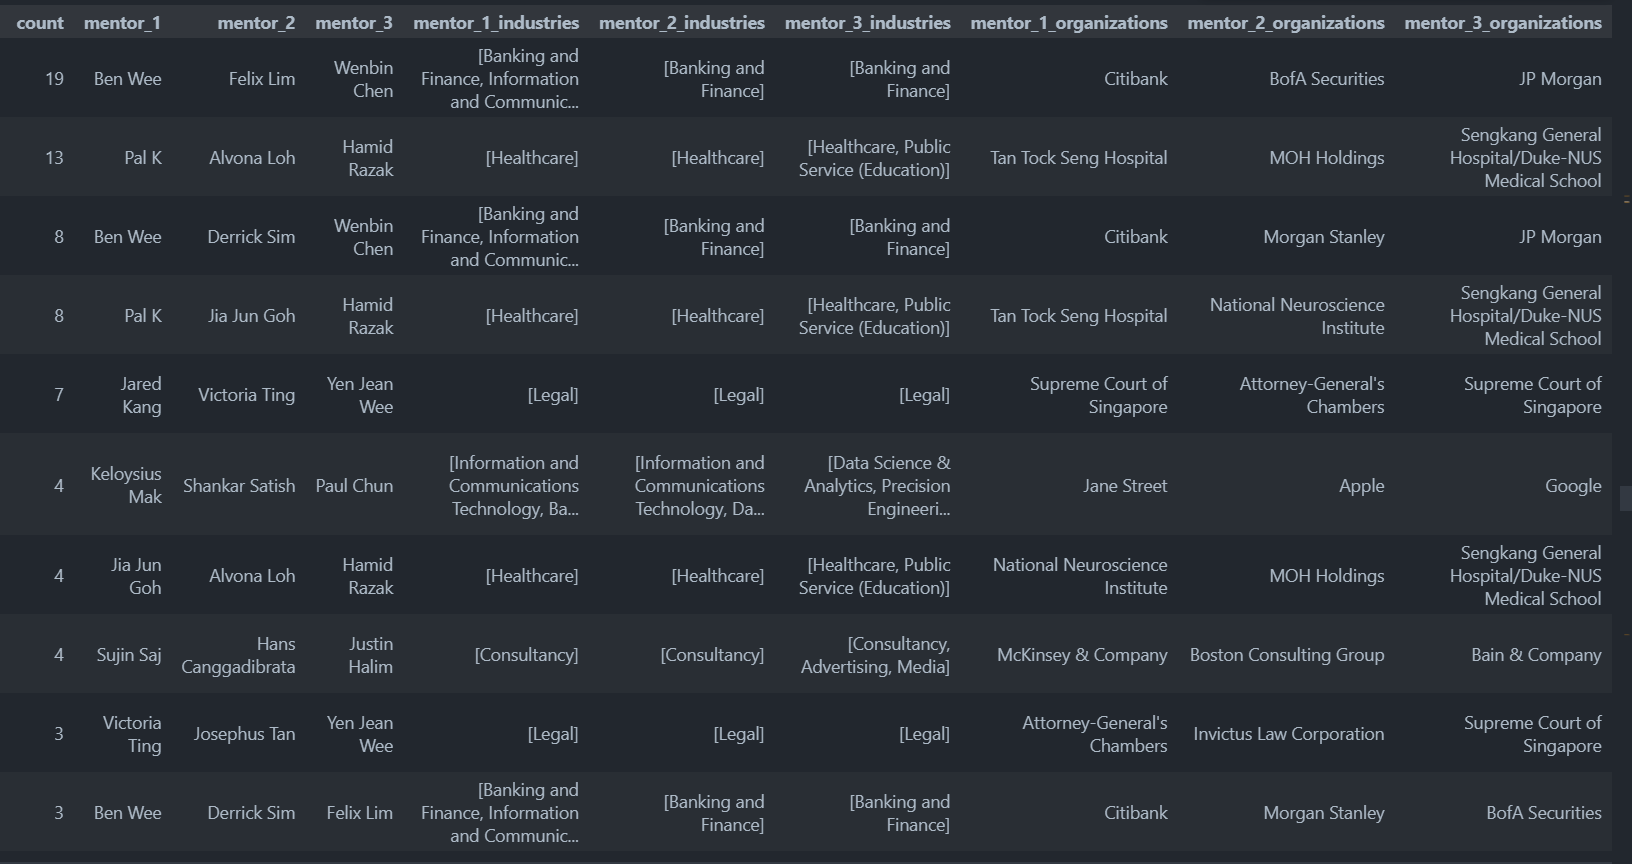
- Organizations Commonly Chosen together<br/>
    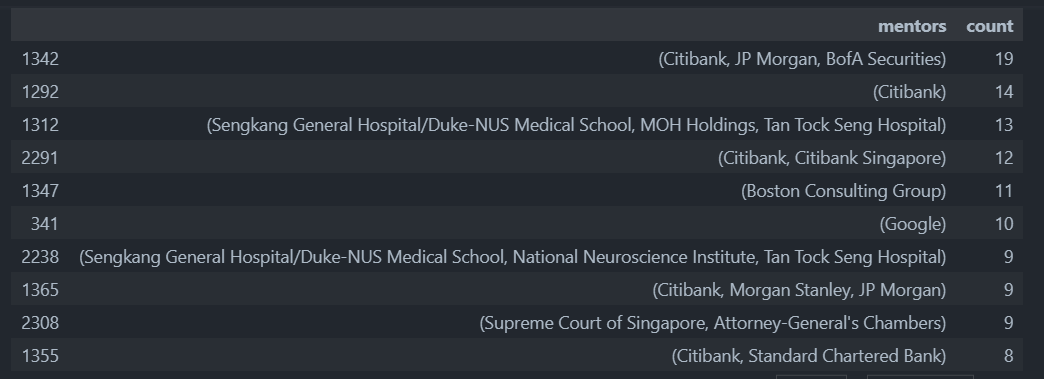
- Association Rule Mining's top 12 rules based on confidence threshold of 0.75 and min_support of 0.001
    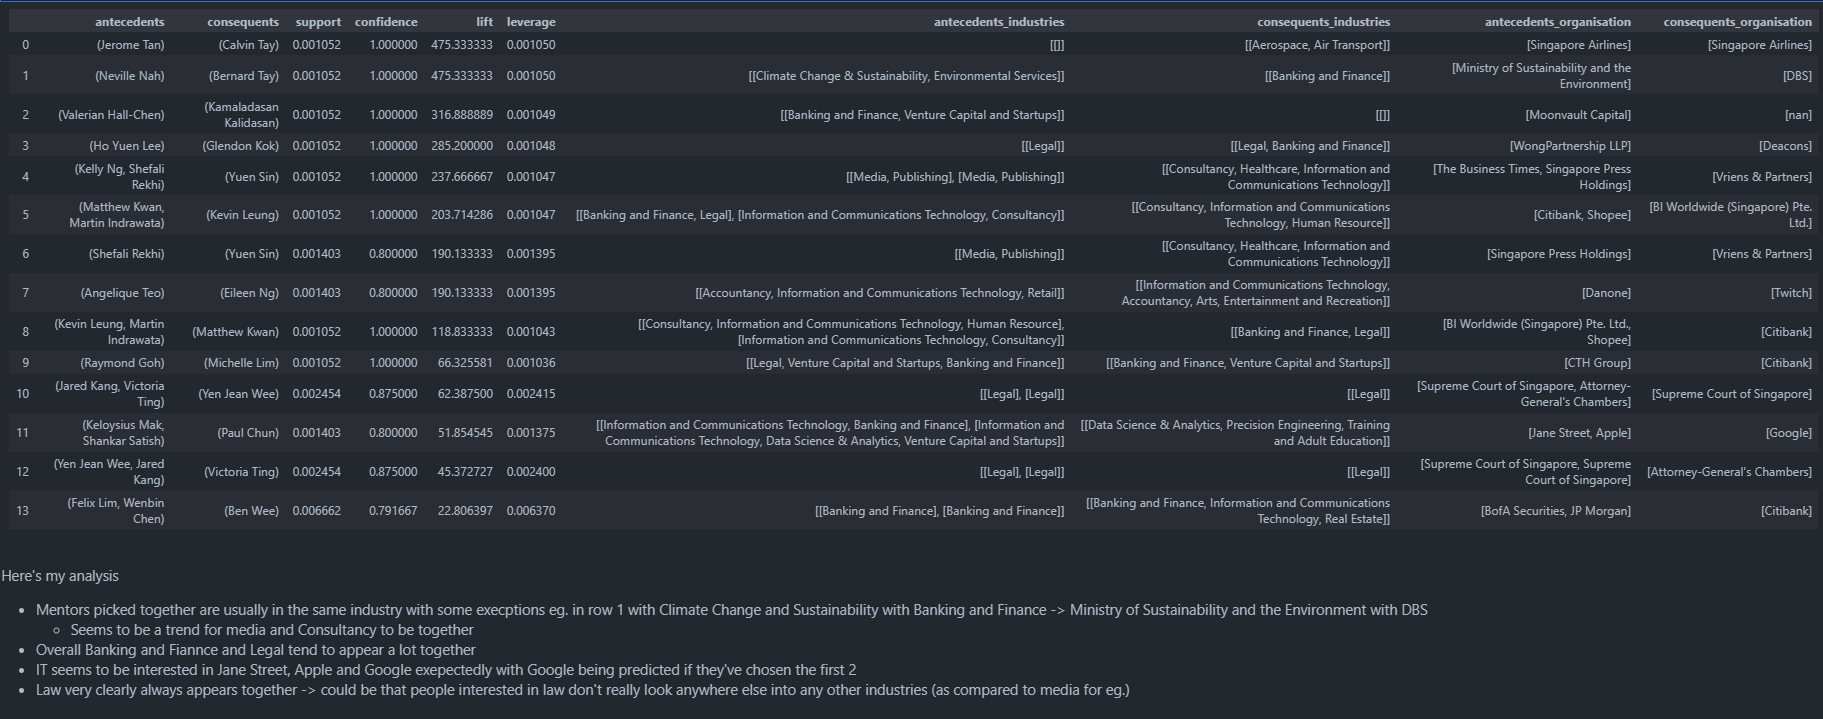
- Association Rule Mining with industry (first industry in the list of industries) based on confidence threshold 0.50 and min_support 0.001
    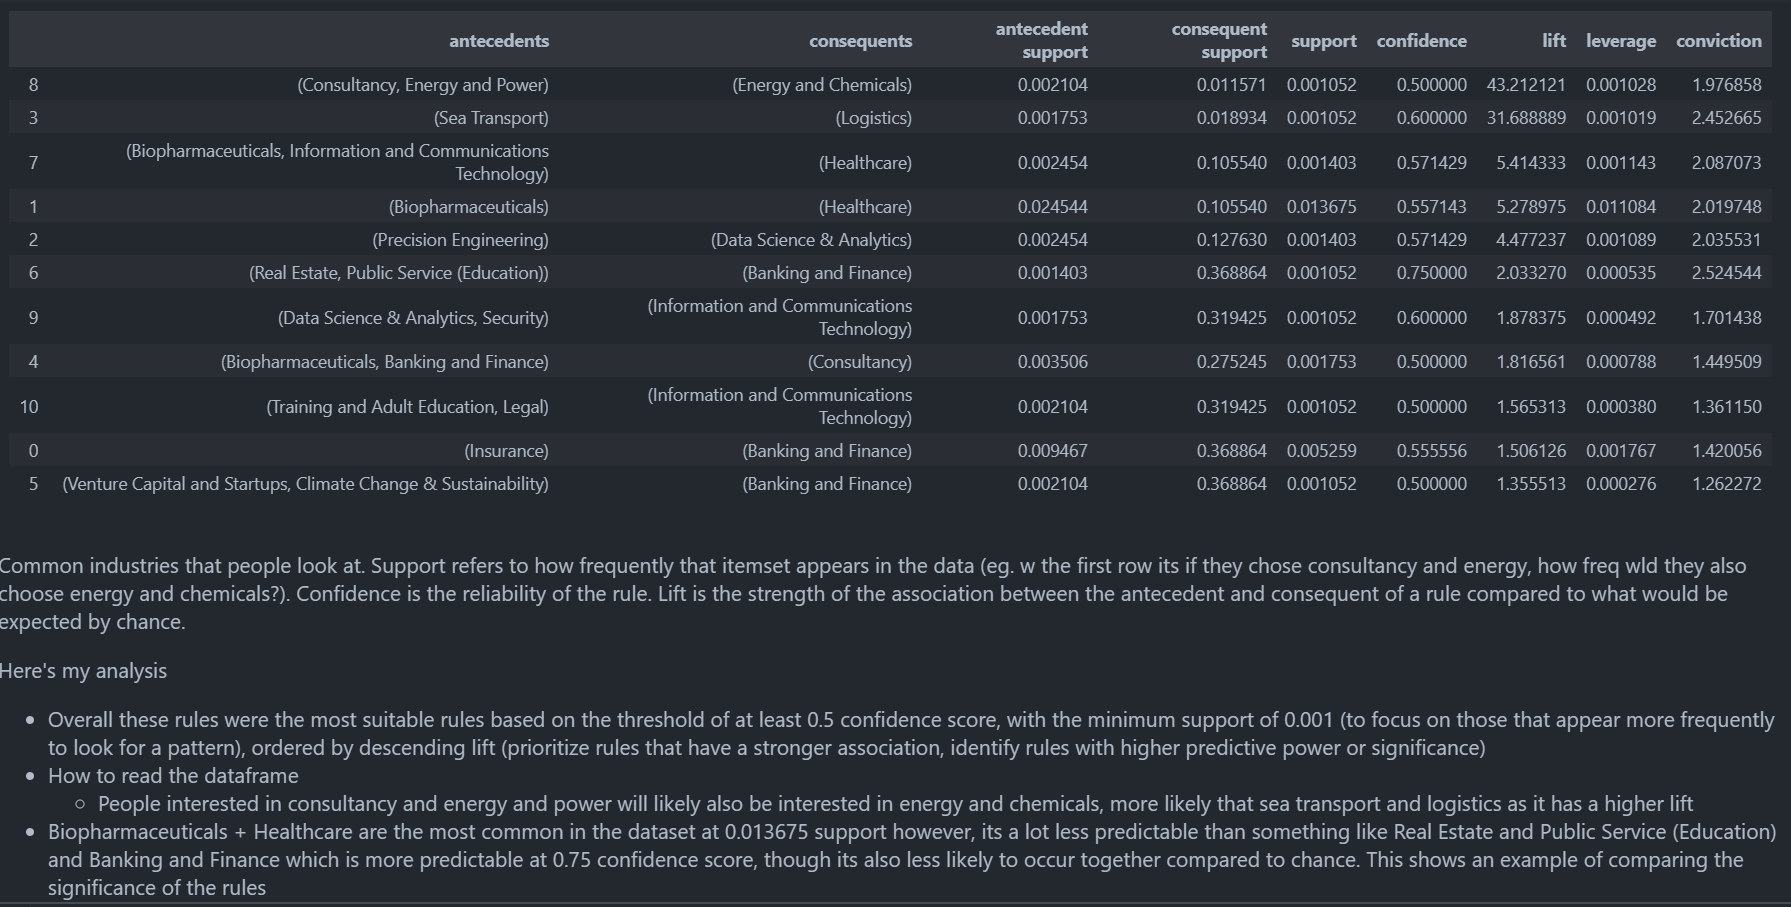

The confidence values are actually worse in the industry one,, cld be because ppl are more likely to pick mentors in the same industry.

Common mentors together

In [30]:
import itertools

# Combine mentor columns into a single column
df_per_application['mentors'] = df_per_application[['mentor_1', 'mentor_2', 'mentor_3']].apply(lambda x: frozenset(x), axis=1)

# Group by mentor combinations (as frozensets) and count the occurrences
mentor_combinations = df_per_application.groupby('mentors').size().reset_index(name='count')

# Sort mentor combinations by count in descending order
mentor_combinations = mentor_combinations.sort_values('count', ascending=False)

mentor_combinations.head(10)

,mentors,count
1500,"(Ben Wee, Felix Lim, Wenbin Chen)",19
1354,"(Alvona Loh, Hamid Razak, Pal K)",13
2513,"(Hamid Razak, Pal K, Jia Jun Goh)",8
1353,"(Derrick Sim, Ben Wee, Wenbin Chen)",8
2502,"(Yen Jean Wee, Jared Kang, Victoria Ting)",7
1447,"(Justin Halim, Hans Canggadibrata, Sujin Saj)",4
2514,"(Alvona Loh, Hamid Razak, Jia Jun Goh)",4
1537,"(Paul Chun, Keloysius Mak, Shankar Satish)",4
1979,"(Kevin Leung, Matthew Kwan, Martin Indrawata)",3
1651,"(Derrick Sim, Ben Wee, Felix Lim)",3


In [28]:
df = pd.read_csv('data/mentors.csv')
df['industries'] = df['industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])

mentors_info = {}
for index, row in df.iterrows():
    mentors_info[row['mentor_name']] = {
        'industries': row['industries'],
        'organisation': row['organisation']
    }

In [31]:
# Convert frozensets back to sets
mentor_combinations['mentors'] = mentor_combinations['mentors'].apply(lambda x: list(x))

# Split mentors into separate columns
mentor_combinations[['mentor_1', 'mentor_2', 'mentor_3']] = mentor_combinations['mentors'].apply(pd.Series)

# Drop the original 'mentors' column
# mentor_combinations = mentor_combinations.drop('mentors', axis=1)

# get their industries and organizations for each mentor using mentors_info
mentor_combinations['mentor_1_industries'] = mentor_combinations['mentor_1'].apply(lambda x: mentors_info[x]['industries'])
mentor_combinations['mentor_2_industries'] = mentor_combinations['mentor_2'].apply(lambda x: mentors_info[x]['industries'] if x in mentors_info else [])
mentor_combinations['mentor_3_industries'] = mentor_combinations['mentor_3'].apply(lambda x: mentors_info[x]['industries'] if x in mentors_info else [])
mentor_combinations['mentor_1_organizations'] = mentor_combinations['mentor_1'].apply(lambda x: mentors_info[x]['organisation'] if x in mentors_info else "")
mentor_combinations['mentor_2_organizations'] = mentor_combinations['mentor_2'].apply(lambda x: mentors_info[x]['organisation'] if x in mentors_info else "")
mentor_combinations['mentor_3_organizations'] = mentor_combinations['mentor_3'].apply(lambda x: mentors_info[x]['organisation'] if x in mentors_info else "")

mentor_combinations.head(10)

,mentors,count,mentor_1,mentor_2,mentor_3,mentor_1_industries,mentor_2_industries,mentor_3_industries,mentor_1_organizations,mentor_2_organizations,mentor_3_organizations
1500,"[Ben Wee, Felix Lim, Wenbin Chen]",19,Ben Wee,Felix Lim,Wenbin Chen,"[Banking and Finance, Information and Communications Technology, Real Estate]",[Banking and Finance],[Banking and Finance],Citibank,BofA Securities,JP Morgan
1354,"[Alvona Loh, Hamid Razak, Pal K]",13,Alvona Loh,Hamid Razak,Pal K,[Healthcare],"[Healthcare, Public Service (Education)]",[Healthcare],MOH Holdings,Sengkang General Hospital/Duke-NUS Medical School,Tan Tock Seng Hospital
2513,"[Hamid Razak, Pal K, Jia Jun Goh]",8,Hamid Razak,Pal K,Jia Jun Goh,"[Healthcare, Public Service (Education)]",[Healthcare],[Healthcare],Sengkang General Hospital/Duke-NUS Medical School,Tan Tock Seng Hospital,National Neuroscience Institute
1353,"[Derrick Sim, Ben Wee, Wenbin Chen]",8,Derrick Sim,Ben Wee,Wenbin Chen,[Banking and Finance],"[Banking and Finance, Information and Communications Technology, Real Estate]",[Banking and Finance],Morgan Stanley,Citibank,JP Morgan
2502,"[Yen Jean Wee, Jared Kang, Victoria Ting]",7,Yen Jean Wee,Jared Kang,Victoria Ting,[Legal],[Legal],[Legal],Supreme Court of Singapore,Supreme Court of Singapore,Attorney-General's Chambers
1447,"[Justin Halim, Hans Canggadibrata, Sujin Saj]",4,Justin Halim,Hans Canggadibrata,Sujin Saj,"[Consultancy, Advertising, Media]",[Consultancy],[Consultancy],Bain & Company,Boston Consulting Group,McKinsey & Company
2514,"[Alvona Loh, Hamid Razak, Jia Jun Goh]",4,Alvona Loh,Hamid Razak,Jia Jun Goh,[Healthcare],"[Healthcare, Public Service (Education)]",[Healthcare],MOH Holdings,Sengkang General Hospital/Duke-NUS Medical School,National Neuroscience Institute
1537,"[Paul Chun, Keloysius Mak, Shankar Satish]",4,Paul Chun,Keloysius Mak,Shankar Satish,"[Data Science & Analytics, Precision Engineering, Training and Adult Education]","[Information and Communications Technology, Banking and Finance]","[Information and Communications Technology, Data Science & Analytics, Venture Capital and Startups]",Google,Jane Street,Apple
1979,"[Kevin Leung, Matthew Kwan, Martin Indrawata]",3,Kevin Leung,Matthew Kwan,Martin Indrawata,"[Consultancy, Information and Communications Technology, Human Resource]","[Banking and Finance, Legal]","[Information and Communications Technology, Consultancy]",BI Worldwide (Singapore) Pte. Ltd.,Citibank,Shopee
1651,"[Derrick Sim, Ben Wee, Felix Lim]",3,Derrick Sim,Ben Wee,Felix Lim,[Banking and Finance],"[Banking and Finance, Information and Communications Technology, Real Estate]",[Banking and Finance],Morgan Stanley,Citibank,BofA Securities


Common Organizations together

In [32]:
df_per_application['mentors'] = df_per_application[['mentor_1_organisation', 'mentor_2_organisation', 'mentor_3_organisation']].apply(lambda x: frozenset(x), axis=1)
mentor_combinations = df_per_application.groupby('mentors').size().reset_index(name='count')
mentor_combinations = mentor_combinations.sort_values('count', ascending=False)
pd.set_option('display.max_colwidth', None)

mentor_combinations.head(10)

,mentors,count
1401,"(JP Morgan, Citibank, BofA Securities)",19
1393,(Citibank),14
1331,"(Tan Tock Seng Hospital, Sengkang General Hospital/Duke-NUS Medical School, MOH Holdings)",13
2233,"(Citibank, Citibank Singapore)",12
1137,(Boston Consulting Group),11
379,(Google),10
2341,"(Tan Tock Seng Hospital, Sengkang General Hospital/Duke-NUS Medical School, National Neuroscience Institute)",9
2235,"(Supreme Court of Singapore, Attorney-General's Chambers)",9
1330,"(JP Morgan, Citibank, Morgan Stanley)",9
1279,"(Citibank, Standard Chartered Bank)",8


Those with only 1 value in their frozen sets means its likely that people chose all 3 mentors from the same company.

Explore the likelihood of mentors being chosen together via Association Rule Mining.

In [40]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert the mentor columns into a list of lists (transactions)
mentors = df_per_application[['mentor_1', 'mentor_2', 'mentor_3']].values.tolist()

# Apply one-hot encoding to the transactions
te = TransactionEncoder()
te_array = te.fit_transform(mentors)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori algorithm to find frequent itemsets of size 3
frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True, max_len=3)

# Check if frequent itemsets are found
if frequent_itemsets.empty:
    print("No frequent itemsets found.")
else:
    # Generate association rules from the frequent itemsets
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

    # Sort the rules by lift
    rules = rules.sort_values(by="lift", ascending=False)

    # Print the association rules
    display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(Jerome Tan),(Calvin Tay),0.001052,0.002104,0.001052,1.000000,475.333333,0.001050,inf
12,(Bernard Tay),(Neville Nah),0.002104,0.001052,0.001052,0.500000,475.333333,0.001050,1.997896
14,(Calvin Tay),(Jerome Tan),0.002104,0.001052,0.001052,0.500000,475.333333,0.001050,1.997896
11,(Neville Nah),(Bernard Tay),0.001052,0.002104,0.001052,1.000000,475.333333,0.001050,inf
84,(Shefali Rekhi),"(Kelly Ng, Yuen Sin)",0.001753,0.001403,0.001052,0.600000,427.800000,0.001049,2.496494
...,...,...,...,...,...,...,...,...,...
72,"(Felix Lim, Wenbin Chen)",(Ben Wee),0.008415,0.034712,0.006662,0.791667,22.806397,0.006370,4.633380
30,(Felix Lim),(Wenbin Chen),0.016129,0.025245,0.008415,0.521739,20.666667,0.008008,2.038123
9,(Felix Lim),(Ben Wee),0.016129,0.034712,0.011220,0.695652,20.040404,0.010660,3.171659
69,"(Derrick Sim, Wenbin Chen)",(Ben Wee),0.004909,0.034712,0.002805,0.571429,16.461760,0.002635,2.252338


Which measure to use for points of comparison?
- Support measures the proportion of transactions that contain both the antecedents and consequents. Higher support indicates a stronger association between the items. However, support alone may not be sufficient to identify interesting or meaningful rules.
- Confidence measures the conditional probability of the consequents given the antecedents. Higher confidence indicates a higher likelihood of the consequents occurring when the antecedents are present. Confidence helps to assess the reliability and strength of the association rules.
    - We've already set the confidence threshold to above 0.5 so most if not all of the association rules above have quite high possibilities of occuring when their antecedents are present.
- Lift compares the observed support of a rule with the expected support under the assumption of independence between antecedents and consequents. A lift value greater than 1 suggests a positive association between the items, indicating that the occurrence of the antecedents increases the likelihood of the consequents beyond what would be expected if they were independent.
    - We will be using this measure instead of the support measure as it better shows the strength of the association between those itemsets

In [41]:
rules_filtered = rules[(rules['confidence'] > 0.75)]
rules_filtered.reset_index(inplace=True)
rules_filtered

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,13,(Jerome Tan),(Calvin Tay),0.001052,0.002104,0.001052,1.000000,475.333333,0.001050,inf
1,11,(Neville Nah),(Bernard Tay),0.001052,0.002104,0.001052,1.000000,475.333333,0.001050,inf
2,46,(Valerian Hall-Chen),(Kamaladasan Kalidasan),0.001052,0.003156,0.001052,1.000000,316.888889,0.001049,inf
3,34,(Ho Yuen Lee),(Glendon Kok),0.001052,0.003506,0.001052,1.000000,285.200000,0.001048,inf
4,81,"(Kelly Ng, Shefali Rekhi)",(Yuen Sin),0.001052,0.004208,0.001052,1.000000,237.666667,0.001047,inf
5,88,"(Matthew Kwan, Martin Indrawata)",(Kevin Leung),0.001052,0.004909,0.001052,1.000000,203.714286,0.001047,inf
6,62,(Shefali Rekhi),(Yuen Sin),0.001753,0.004208,0.001403,0.800000,190.133333,0.001395,4.978962
7,6,(Angelique Teo),(Eileen Ng),0.001753,0.004208,0.001403,0.800000,190.133333,0.001395,4.978962
8,87,"(Kevin Leung, Martin Indrawata)",(Matthew Kwan),0.001052,0.008415,0.001052,1.000000,118.833333,0.001043,inf
9,52,(Raymond Goh),(Michelle Lim),0.001052,0.015077,0.001052,1.000000,66.325581,0.001036,inf


In [42]:
# enrich with their industries

df = pd.read_csv('data/mentors.csv')
df['industries'] = df['industries'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])

mentors_info = {}
for index, row in df.iterrows():
    mentors_info[row['mentor_name']] = {
        'industries': row['industries'],
        'organisation': row['organisation']
    }

# enrich rules dataset with industries
rules_enriched = rules_filtered.copy(deep=True)
rules_enriched['antecedents_industries'] = rules_enriched['antecedents'].apply(lambda x: [mentors_info[mentor]['industries'] for mentor in x])
rules_enriched['consequents_industries'] = rules_enriched['consequents'].apply(lambda x: [mentors_info[mentor]['industries'] for mentor in x])
rules_enriched['antecedents_organisation'] = rules_enriched['antecedents'].apply(lambda x: [mentors_info[mentor]['organisation'] for mentor in x])
rules_enriched['consequents_organisation'] = rules_enriched['consequents'].apply(lambda x: [mentors_info[mentor]['organisation'] for mentor in x])

# drop columns
rules_enriched.drop(columns=['index', 'antecedent support', 'consequent support', 'conviction'], inplace=True)
rules_enriched

,antecedents,consequents,support,confidence,lift,leverage,antecedents_industries,consequents_industries,antecedents_organisation,consequents_organisation
0,(Jerome Tan),(Calvin Tay),0.001052,1.000000,475.333333,0.001050,[[]],"[[Aerospace, Air Transport]]",[Singapore Airlines],[Singapore Airlines]
1,(Neville Nah),(Bernard Tay),0.001052,1.000000,475.333333,0.001050,"[[Climate Change & Sustainability, Environmental Services]]",[[Banking and Finance]],[Ministry of Sustainability and the Environment],[DBS]
2,(Valerian Hall-Chen),(Kamaladasan Kalidasan),0.001052,1.000000,316.888889,0.001049,"[[Banking and Finance, Venture Capital and Startups]]",[[]],[Moonvault Capital],[nan]
3,(Ho Yuen Lee),(Glendon Kok),0.001052,1.000000,285.200000,0.001048,[[Legal]],"[[Legal, Banking and Finance]]",[WongPartnership LLP],[Deacons]
4,"(Kelly Ng, Shefali Rekhi)",(Yuen Sin),0.001052,1.000000,237.666667,0.001047,"[[Media, Publishing], [Media, Publishing]]","[[Consultancy, Healthcare, Information and Communications Technology]]","[The Business Times, Singapore Press Holdings]",[Vriens & Partners]
5,"(Matthew Kwan, Martin Indrawata)",(Kevin Leung),0.001052,1.000000,203.714286,0.001047,"[[Banking and Finance, Legal], [Information and Communications Technology, Consultancy]]","[[Consultancy, Information and Communications Technology, Human Resource]]","[Citibank, Shopee]",[BI Worldwide (Singapore) Pte. Ltd.]
6,(Shefali Rekhi),(Yuen Sin),0.001403,0.800000,190.133333,0.001395,"[[Media, Publishing]]","[[Consultancy, Healthcare, Information and Communications Technology]]",[Singapore Press Holdings],[Vriens & Partners]
7,(Angelique Teo),(Eileen Ng),0.001403,0.800000,190.133333,0.001395,"[[Accountancy, Information and Communications Technology, Retail]]","[[Information and Communications Technology, Accountancy, Arts, Entertainment and Recreation]]",[Danone],[Twitch]
8,"(Kevin Leung, Martin Indrawata)",(Matthew Kwan),0.001052,1.000000,118.833333,0.001043,"[[Consultancy, Information and Communications Technology, Human Resource], [Information and Communications Technology, Consultancy]]","[[Banking and Finance, Legal]]","[BI Worldwide (Singapore) Pte. Ltd., Shopee]",[Citibank]
9,(Raymond Goh),(Michelle Lim),0.001052,1.000000,66.325581,0.001036,"[[Legal, Venture Capital and Startups, Banking and Finance]]","[[Banking and Finance, Venture Capital and Startups]]",[CTH Group],[Citibank]


Here's my analysis
- Mentors picked together are usually in the same industry with some execptions eg. in row 1 with Climate Change and Sustainability with Banking and Finance -> Ministry of Sustainability and the Environment with DBS
    - Seems to be a trend for media and Consultancy to be together
- Overall Banking and Fiannce and Legal tend to appear a lot together
- IT seems to be interested in Jane Street, Apple and Google exepectedly with Google being predicted if they've chosen the first 2
- Law very clearly always appears together -> could be that people interested in law don't really look anywhere else into any other industries (as compared to media for eg.)

Explore the same for industries

In [39]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert the mentor columns into a list of lists (transactions)

# pick the first of industries and reassign value
df_per_application_industry = df_per_application.copy(deep=True)
df_per_application_industry['mentor_1_industries'] = df_per_application_industry['mentor_1_industries'].apply(lambda x: x[0] if len(x) > 0 else "")
df_per_application_industry['mentor_2_industries'] = df_per_application_industry['mentor_2_industries'].apply(lambda x: x[0] if len(x) > 0 else "")
df_per_application_industry['mentor_3_industries'] = df_per_application_industry['mentor_3_industries'].apply(lambda x: x[0] if len(x) > 0 else "")

mentors = df_per_application_industry[['mentor_1_industries', 'mentor_2_industries', 'mentor_3_industries']].values.tolist()

# Apply one-hot encoding to the transactions
te = TransactionEncoder()
te_array = te.fit_transform(mentors)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori algorithm to find frequent itemsets of size 3
frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True, max_len=3)

# Check if frequent itemsets are found
if frequent_itemsets.empty:
    print("No frequent itemsets found.")
else:
    # Generate association rules from the frequent itemsets
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

    # Sort the rules by lift
    rules = rules.sort_values(by="lift", ascending=False)

    # Print the association rules
    display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,"(Consultancy, Energy and Power)",(Energy and Chemicals),0.002104,0.011571,0.001052,0.500000,43.212121,0.001028,1.976858
3,(Sea Transport),(Logistics),0.001753,0.018934,0.001052,0.600000,31.688889,0.001019,2.452665
7,"(Biopharmaceuticals, Information and Communications Technology)",(Healthcare),0.002454,0.105540,0.001403,0.571429,5.414333,0.001143,2.087073
1,(Biopharmaceuticals),(Healthcare),0.024544,0.105540,0.013675,0.557143,5.278975,0.011084,2.019748
2,(Precision Engineering),(Data Science & Analytics),0.002454,0.127630,0.001403,0.571429,4.477237,0.001089,2.035531
6,"(Real Estate, Public Service (Education))",(Banking and Finance),0.001403,0.368864,0.001052,0.750000,2.033270,0.000535,2.524544
9,"(Data Science & Analytics, Security)",(Information and Communications Technology),0.001753,0.319425,0.001052,0.600000,1.878375,0.000492,1.701438
4,"(Biopharmaceuticals, Banking and Finance)",(Consultancy),0.003506,0.275245,0.001753,0.500000,1.816561,0.000788,1.449509
10,"(Training and Adult Education, Legal)",(Information and Communications Technology),0.002104,0.319425,0.001052,0.500000,1.565313,0.000380,1.361150
0,(Insurance),(Banking and Finance),0.009467,0.368864,0.005259,0.555556,1.506126,0.001767,1.420056


Common industries that people look at. Support refers to how frequently that itemset appears in the data (eg. w the first row its if they chose consultancy and energy, how freq wld they also choose energy and chemicals?). Confidence is the reliability of the rule. Lift is the strength of the association between the antecedent and consequent of a rule compared to what would be expected by chance.

Here's my analysis
- Overall these rules were the most suitable rules based on the threshold of at least 0.5 confidence score, with the minimum support of 0.001 (to focus on those that appear more frequently to look for a pattern), ordered by descending lift (prioritize rules that have a stronger association, identify rules with higher predictive power or significance)
- How to read the dataframe
    - People interested in consultancy and energy and power will likely also be interested in energy and chemicals, more likely that sea transport and logistics as it has a higher lift
- Biopharmaceuticals + Healthcare are the most common in the dataset at 0.013675 support however, its a lot less predictable than something like Real Estate and Public Service (Education) and Banking and Finance which is more predictable at 0.75 confidence score, though its also less likely to occur together compared to chance. This shows an example of comparing the significance of the rules

##### Displaying association rules relationships

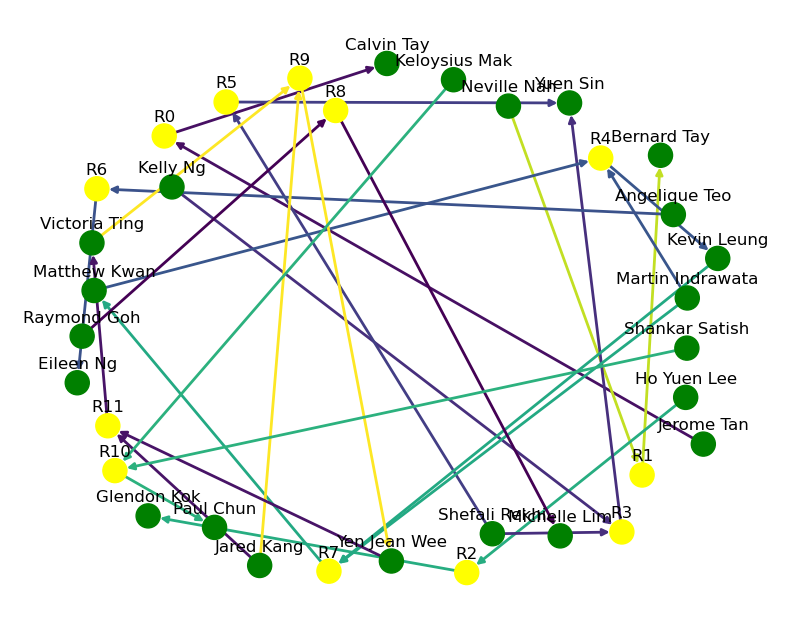

In [93]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()

    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs = ['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

    for i in range(rules_to_show):
        G1.add_nodes_from(["R"+str(i)])

        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i], weight=2)

        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i], weight=2)

    for node in G1:
        found_a_string = False
        for item in strs:
            if node == item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')

    edges = list(G1.edges())  # Convert edges to a list

    colors = [G1[u][v]['color'] for u, v in edges]
    weights = [G1[u][v]['weight'] for u, v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)

    fig, ax = plt.subplots(figsize=(10, 8))
    nx.draw(G1, pos, edgelist=edges, node_color=color_map, edge_color=colors, width=weights, font_size=16, with_labels=False, ax=ax)

    for p in pos:
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos, ax=ax)
    plt.show()

draw_graph(rules_filtered, 12)

To analyze the results and understand which people are likely to choose certain mentors together, we can look at the labels. Each cluster represents a group of individuals who share similar text features.

In [24]:
# # Explore Cluster Characteristics
# for cluster_label in range(3):  # Iterate over each cluster label
#     cluster_data = df_per_application[df_per_application['cluster_label'] == cluster_label]
    
#     # Print cluster label and count
#     print(f"Cluster {cluster_label}: {len(cluster_data)} individuals")
    
#     # Print sample individuals in the cluster
#     print("Sample Individuals:")
#     display(cluster_data.head())
#     print("----------------------------------------")

# # Identify Patterns
# for cluster_label in range(3):  # Iterate over each cluster label
#     cluster_data = df_per_application[df_per_application['cluster_label'] == cluster_label]
    
#     # Count mentor combinations within the cluster
#     mentor_combinations = cluster_data.groupby(['mentor_1', 'mentor_2', 'mentor_3']).size().reset_index(name='count')
    
#     # Sort mentor combinations by count in descending order
#     mentor_combinations = mentor_combinations.sort_values('count', ascending=False)
    
#     # Print top mentor combinations in the cluster
#     print(f"Top Mentor Combinations in Cluster {cluster_label}:")
#     display(mentor_combinations.head())
#     print("----------------------------------------")

Cluster 0: 203 individuals
Sample Individuals:


,mentor_1,mentor_2,mentor_3,year,mentor_1_industries,mentor_1_organisation,mentor_2_industries,mentor_2_organisation,mentor_3_industries,mentor_3_organisation,cluster_label
47,Victoria Yeow,Zaizhuang Cheng,Steve Xie,2020w3,[Banking and Finance],Francisco Partners,"['Venture Capital and Startups', 'Banking and ...",Hodlnaut,"['Venture Capital and Startups', 'Manufacturin...",Careershe,0
112,Claire Josephine O'Callaghan,Cheryl Sim,Wei Xuan Tan,2020w3,"[Venture Capital and Startups, Training and Ad...",NUS Enterprise,"['Consultancy', 'Training and Adult Education']",Rohei Learning and Consulting,['Banking and Finance'],GIC,0
124,Chen Wenying,Paul Chun,Samuel Chin,2020w3,"[Banking and Finance, Venture Capital and Star...",Moonvault Capital,"['Data Science & Analytics', 'Precision Engine...",Google,"['Energy and Power', 'Human Resource']",Vitol Asia Pte Ltd,0
128,Joo Lee Lim,Cheng Xun Chua,Zaizhuang Cheng,2020w3,"[Media, Advertising]",Weave Pte Ltd,"['Consultancy', 'Retail', 'Venture Capital and...",Shopee,"['Venture Capital and Startups', 'Banking and ...",Hodlnaut,0
329,Chen Wenying,Chen Wenying,Chen Wenying,2020w3,"[Banking and Finance, Venture Capital and Star...",Moonvault Capital,"['Banking and Finance', 'Venture Capital and S...",Moonvault Capital,"['Banking and Finance', 'Venture Capital and S...",Moonvault Capital,0


----------------------------------------
Cluster 1: 334 individuals
Sample Individuals:


,mentor_1,mentor_2,mentor_3,year,mentor_1_industries,mentor_1_organisation,mentor_2_industries,mentor_2_organisation,mentor_3_industries,mentor_3_organisation,cluster_label
0,Aaqib Alvi,Abhi Parikh,Alex Loh,2020w3,[Early Childhood Care and Education],Sustainable Living Lab,"['Consultancy', 'Information and Communication...",Grab,"['Healthcare', 'Consultancy', 'Human Resource']",Actxa Wellness,1
9,Fabian Kho,Andy Soh,Alan Lim,2020w3,[Consultancy],Arthur D. Little,['Consultancy'],Accenture (Strategy & Consulting),"['Energy and Chemicals', 'Human Resource', 'Co...",Baker Hughes,1
22,Cheng Xun Chua,Jitin Sharma,Andy Soh,2020w3,"[Consultancy, Retail, Venture Capital and Star...",Shopee,['Banking and Finance'],Standard Chartered,['Consultancy'],Accenture (Strategy & Consulting),1
28,Fabian Kho,Madhumitha Ardhanari,Nicole Lim,2020w3,[Consultancy],Arthur D. Little,['Consultancy'],Senior Sustainability Strategist,"['Banking and Finance', 'Consultancy', 'Climat...",Aberdeen Standard Investments,1
58,Patricia Marin Lucas,Abhineet Kaul,Niranjana K. Doraraj,2020w3,[Legal],Drew & Napier LLC,['Consultancy'],Frost & Sullivan,"['Consultancy', 'Retail']",SME Centre@SICCI,1


----------------------------------------
Cluster 2: 775 individuals
Sample Individuals:


,mentor_1,mentor_2,mentor_3,year,mentor_1_industries,mentor_1_organisation,mentor_2_industries,mentor_2_organisation,mentor_3_industries,mentor_3_organisation,cluster_label
2,Daniel Ho,Andee Chua,Brad Verne,2020w3,[Information and Communications Technology],Mixpanel APAC Pte. Ltd.,"['Social Impact & CSR', 'Human Resource']",HubSpot,"['Human Resource', 'Media']",The Coca-Cola Company,2
7,Christine Yip,Priya Bellino,Benjamin Oh,2020w3,"[Legal, Venture Capital and Startups]",Vulpes Ventures,"['Banking and Finance', 'Climate Change & Sust...","Aquabaleno, Ex-Goldman Sachs",['Security'],Singapore Civil Defence Force,2
8,William Santosa Lim,Dennis Ly,Erwin Low,2020w3,[Banking and Finance],Baring Private Equity Asia,['Information and Communications Technology'],Cyber Security Agency,['Public Service (Education)'],Pathlight School (former),2
14,Matthew Kwan,Kevin Leung,Benjamin Oh,2020w3,"[Banking and Finance, Legal]",Citibank,"['Consultancy', 'Information and Communication...",BI Worldwide (Singapore) Pte. Ltd.,['Security'],Singapore Civil Defence Force,2
21,Joan Li,Brad Verne,Abigail Browne,2020w3,[Public Service (Education)],Boston Consulting Group,"['Human Resource', 'Media']",The Coca-Cola Company,['Human Resource'],Standard Chartered,2


----------------------------------------
Top Mentor Combinations in Cluster 0:


,mentor_1,mentor_2,mentor_3,count
59,Dalal Alghawas,Yee Hean Teo,Kesh Jiang,2
0,Abhishek Kasina,Abhishek Kasina,Abhishek Kasina,1
139,Nirali Zaveri,Christopher Quek,Winston Seow,1
129,Michelle Lim,Santosh Rao,Amitava Ray,1
130,Michelle Lim,Shanaz Rauff,Pin Duangdee,1


----------------------------------------
Top Mentor Combinations in Cluster 1:


,mentor_1,mentor_2,mentor_3,count
171,Justin Halim,Sujin Saj,Hans Canggadibrata,2
260,Samantha Tan (McKinsey & Company),Eileen Tan,Zoe Ong,2
156,Joceline Yong,Yee Hui Chia,Toshin Sequeira,2
0,Aaqib Alvi,Abhi Parikh,Abhineet Kaul,1
218,Namita Mohinani,Shannon Kong,Arti Ram,1


----------------------------------------
Top Mentor Combinations in Cluster 2:


,mentor_1,mentor_2,mentor_3,count
285,Hamid Razak,Pal K,Alvona Loh,5
283,Hamid Razak,Jia Jun Goh,Pal K,4
279,Hamid Razak,Alvona Loh,Pal K,3
36,Alvona Loh,Pal K,Jonathan Kuek,3
723,Yen Jean Wee,Victoria Ting,Jared Kang,3


----------------------------------------
